# Experiments on 2D Cellular Automata with PyTorch

In [1]:
# Base Data Science snippet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from tqdm import tqdm_notebook

%matplotlib inline
%load_ext autoreload
%autoreload 2

# 2D Cellular Automata

## Test of Conv2D

In [38]:
import torch
import torch.nn as nn


state = torch.zeros((5,5))
state[2,1:4] = 1
state = state[None,None,:,:]
state

tensor([[[[0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          [0., 1., 1., 1., 0.],
          [0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.]]]])

In [22]:
# Create conv2D layer
m = nn.Conv2d(1,1,3, stride=1,padding = 1,bias = False)

In [23]:
neighbors_filter = torch.ones(3,3)
neighbors_filter[1,1] = 0
neighbors_filter

tensor([[1., 1., 1.],
        [1., 0., 1.],
        [1., 1., 1.]])

In [24]:
m.weight

Parameter containing:
tensor([[[[ 2.0548e-01, -1.1528e-01,  1.3073e-03],
          [ 3.3287e-01,  1.6706e-01, -2.9594e-05],
          [ 3.2940e-01, -2.1456e-01,  2.7126e-01]]]], requires_grad=True)

In [25]:
m.weight = torch.nn.Parameter(neighbors_filter[None,None,:,:])

In [26]:
m.weight

Parameter containing:
tensor([[[[1., 1., 1.],
          [1., 0., 1.],
          [1., 1., 1.]]]], requires_grad=True)

In [27]:
output = m(state)
output

tensor([[[[0., 0., 0., 0., 0.],
          [0., 1., 1., 1., 0.],
          [0., 1., 0., 1., 0.],
          [0., 1., 1., 1., 0.],
          [0., 0., 0., 0., 0.]]]], grad_fn=<ThnnConv2DBackward>)

In [28]:
m(output)

tensor([[[[1., 2., 3., 2., 1.],
          [2., 2., 4., 2., 2.],
          [3., 4., 8., 4., 3.],
          [2., 2., 4., 2., 2.],
          [1., 2., 3., 2., 1.]]]], grad_fn=<ThnnConv2DBackward>)

## Implementing rules of Conway's game of life
https://en.wikipedia.org/wiki/Conway%27s_Game_of_Life
> 1. Any live cell with two or three live neighbours survives.
> 2. Any dead cell with three live neighbours becomes a live cell.
> 3. All other live cells die in the next generation. Similarly, all other dead cells stay dead.

In [34]:
def step(state):
    
    neighbors = m(state)
    
    rule_alive = ((neighbors >= 2) * (neighbors <= 3)).type(torch.IntTensor)
    rule_dead = (neighbors == 3).type(torch.IntTensor)
    
    next_state = rule_alive * state + rule_dead * (1 - state)
    
    return next_state

In [39]:
state = torch.zeros((5,5))
state[2,1:4] = 1
state = state[None,None,:,:]
state

tensor([[[[0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          [0., 1., 1., 1., 0.],
          [0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.]]]])

In [41]:
step(state)

tensor([[[[0., 0., 0., 0., 0.],
          [0., 0., 1., 0., 0.],
          [0., 0., 1., 0., 0.],
          [0., 0., 1., 0., 0.],
          [0., 0., 0., 0., 0.]]]])

In [42]:
step(step(state))

tensor([[[[0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          [0., 1., 1., 1., 0.],
          [0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.]]]])

In [44]:
torch.squeeze(state).numpy()

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 1., 1., 1., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]], dtype=float32)

## Display

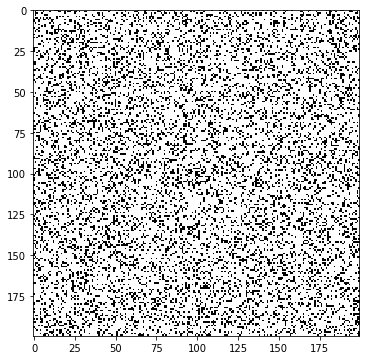

In [211]:
size = 200
n = 10000

state = torch.zeros(size,size)
state[np.random.randint(0,size,size = (2,n))] = 1
state = state[None,None,:,:]

plt.figure(figsize = (6,6))
plt.imshow(convert_rgb(torch.squeeze(state).numpy()))
plt.show()

In [212]:
def make_game_of_life(state,n):

    states = []

    states.append(torch.squeeze(state).numpy())

    for i in range(n):
        state = step(state)
        states.append(torch.squeeze(state).numpy())

    return states

def convert_rgb(x):
    return (np.repeat((1-x)[:,:,None],3,2) * 255).astype(np.uint8)

In [213]:
states = make_game_of_life(state,1000)
states = [convert_rgb(x) for x in states]

In [214]:
import matplotlib
import matplotlib.animation as animation
from ipywidgets import interact,widgets
from PIL import Image

In [216]:
fps = 5

# Prepare widgets
play = widgets.Play(
    value=0,
    min=0,
    max=len(states) - 1,
    step=1,
    interval=int(1000/fps),
    description="Press play",
    disabled=False
)

slider = widgets.IntSlider(min = 0,value = 0,max = len(states) - 1,step = 1)
widgets.jslink((play, 'value'), (slider, 'value'))


# Visualize frames and widgets
@interact(i = play)
def show(i):
#     plt.close()
    plt.figure(figsize = (15,15))
    plt.imshow(states[i])
#     plt.show()
#     img = Image.fromarray(states[i])
#     return img

display(slider)

interactive(children=(Play(value=0, description='Press play', interval=200, max=1000), Output()), _dom_classes…

IntSlider(value=0, max=1000)

KeyboardInterrupt: 

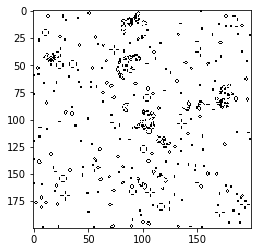

In [217]:
from IPython.display import HTML,display

fig = plt.figure(figsize = (4,4))
imgs = [[plt.imshow(state,animated = True)] for state in states]
ani = animation.ArtistAnimation(fig, imgs, interval=200, blit=True,)
display(HTML(ani.to_html5_video()))
plt.close()